In [1]:
import pathlib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

BATCH_SIZE = 32
IMAGE_SIZE = (512, 512)

data_dir = str((pathlib.Path.cwd().parent /
                'data/train_image/regrouped').resolve())
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                    validation_split=0.2,
                                                                    subset="training",
                                                                    seed=137,
                                                                    image_size=IMAGE_SIZE,
                                                                    batch_size=BATCH_SIZE)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir,
                                                                         validation_split=0.2,
                                                                         subset="validation",
                                                                         seed=137,
                                                                         image_size=IMAGE_SIZE,
                                                                         batch_size=BATCH_SIZE)

class_names = train_dataset.class_names
print(class_names)

Found 1164 files belonging to 3 classes.
Using 932 files for training.
Found 1164 files belonging to 3 classes.
Using 232 files for validation.
['0', '1', '2']


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import (exposure, measure, morphology, segmentation, color, filters)

%matplotlib inline

def segment_from_image(
    image_array: np.ndarray, erosion=2, closing=4, dilation=16
):
    """
    Segment critical parts from image array
    :param image_array: Image in numpy array form
    :param erosion: erosion connectivity factor
    :param closing: closing connectivity factor
    :param dilation: dilation connectivity factor
    :return: transformed image array
    """
    # Assert that image is of stipulated shape
    try:
        assert len(image_array.shape) == 3 and image_array.shape[2] == 3
    except AssertionError:
        logger.error("Image array must be of shape (?, ?, 3)")

    # Type casting as int and create binary mask using mean value
    image_array = image_array.astype("uint8")
    image_array = exposure.equalize_hist(image_array)
    image_array_binary_mask = image_array < image_array.mean()

    # Clear binary mask boarder
    for channel in range(image_array_binary_mask.shape[2]):
        image_array_binary_mask[:, :, channel] = segmentation.clear_border(
            image_array_binary_mask[:, :, channel]
        )

    # Label the image and dim the binary mask according to labelled region
    labelled_image = measure.label(image_array_binary_mask)
    regions = measure.regionprops(labelled_image)
    areas = [(region.area, region.label) for region in regions]
    areas.sort(key=lambda x: x[0])

    if len(areas) > 2:
        max_area = areas[-5][0]
        for region in regions:
            if region.area < max_area:
                for channel in region.coords:
                    image_array_binary_mask[
                        channel[0], channel[1], channel[2]
                    ] = 0

    # Additional CV steps to further segment core areas from the rest of the image
    image_array_binary_mask = morphology.binary_erosion(
        image_array_binary_mask, selem=np.ones((erosion,) * 3)
    )
    image_array_binary_mask = morphology.binary_closing(
        image_array_binary_mask, selem=np.ones((closing,) * 3)
    )
    image_array_binary_mask = morphology.binary_dilation(
        image_array_binary_mask, selem=np.ones((dilation,) * 3)
    )

    return np.multiply(image_array_binary_mask, image_array)

# https://www.kaggle.com/ankasor/improved-lung-segmentation-using-watershed

def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < image.mean()
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, 0*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

c:\users\luter\repository\cs5242-medical-image-classifier\.venv\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
c:\users\luter\repository\cs5242-medical-image-classifier\.venv\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
c:\users\luter\repository\cs5242-medical-image-classifier\.venv\lib\site-packages\skimage\exposure\exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
c:\users\luter\repository

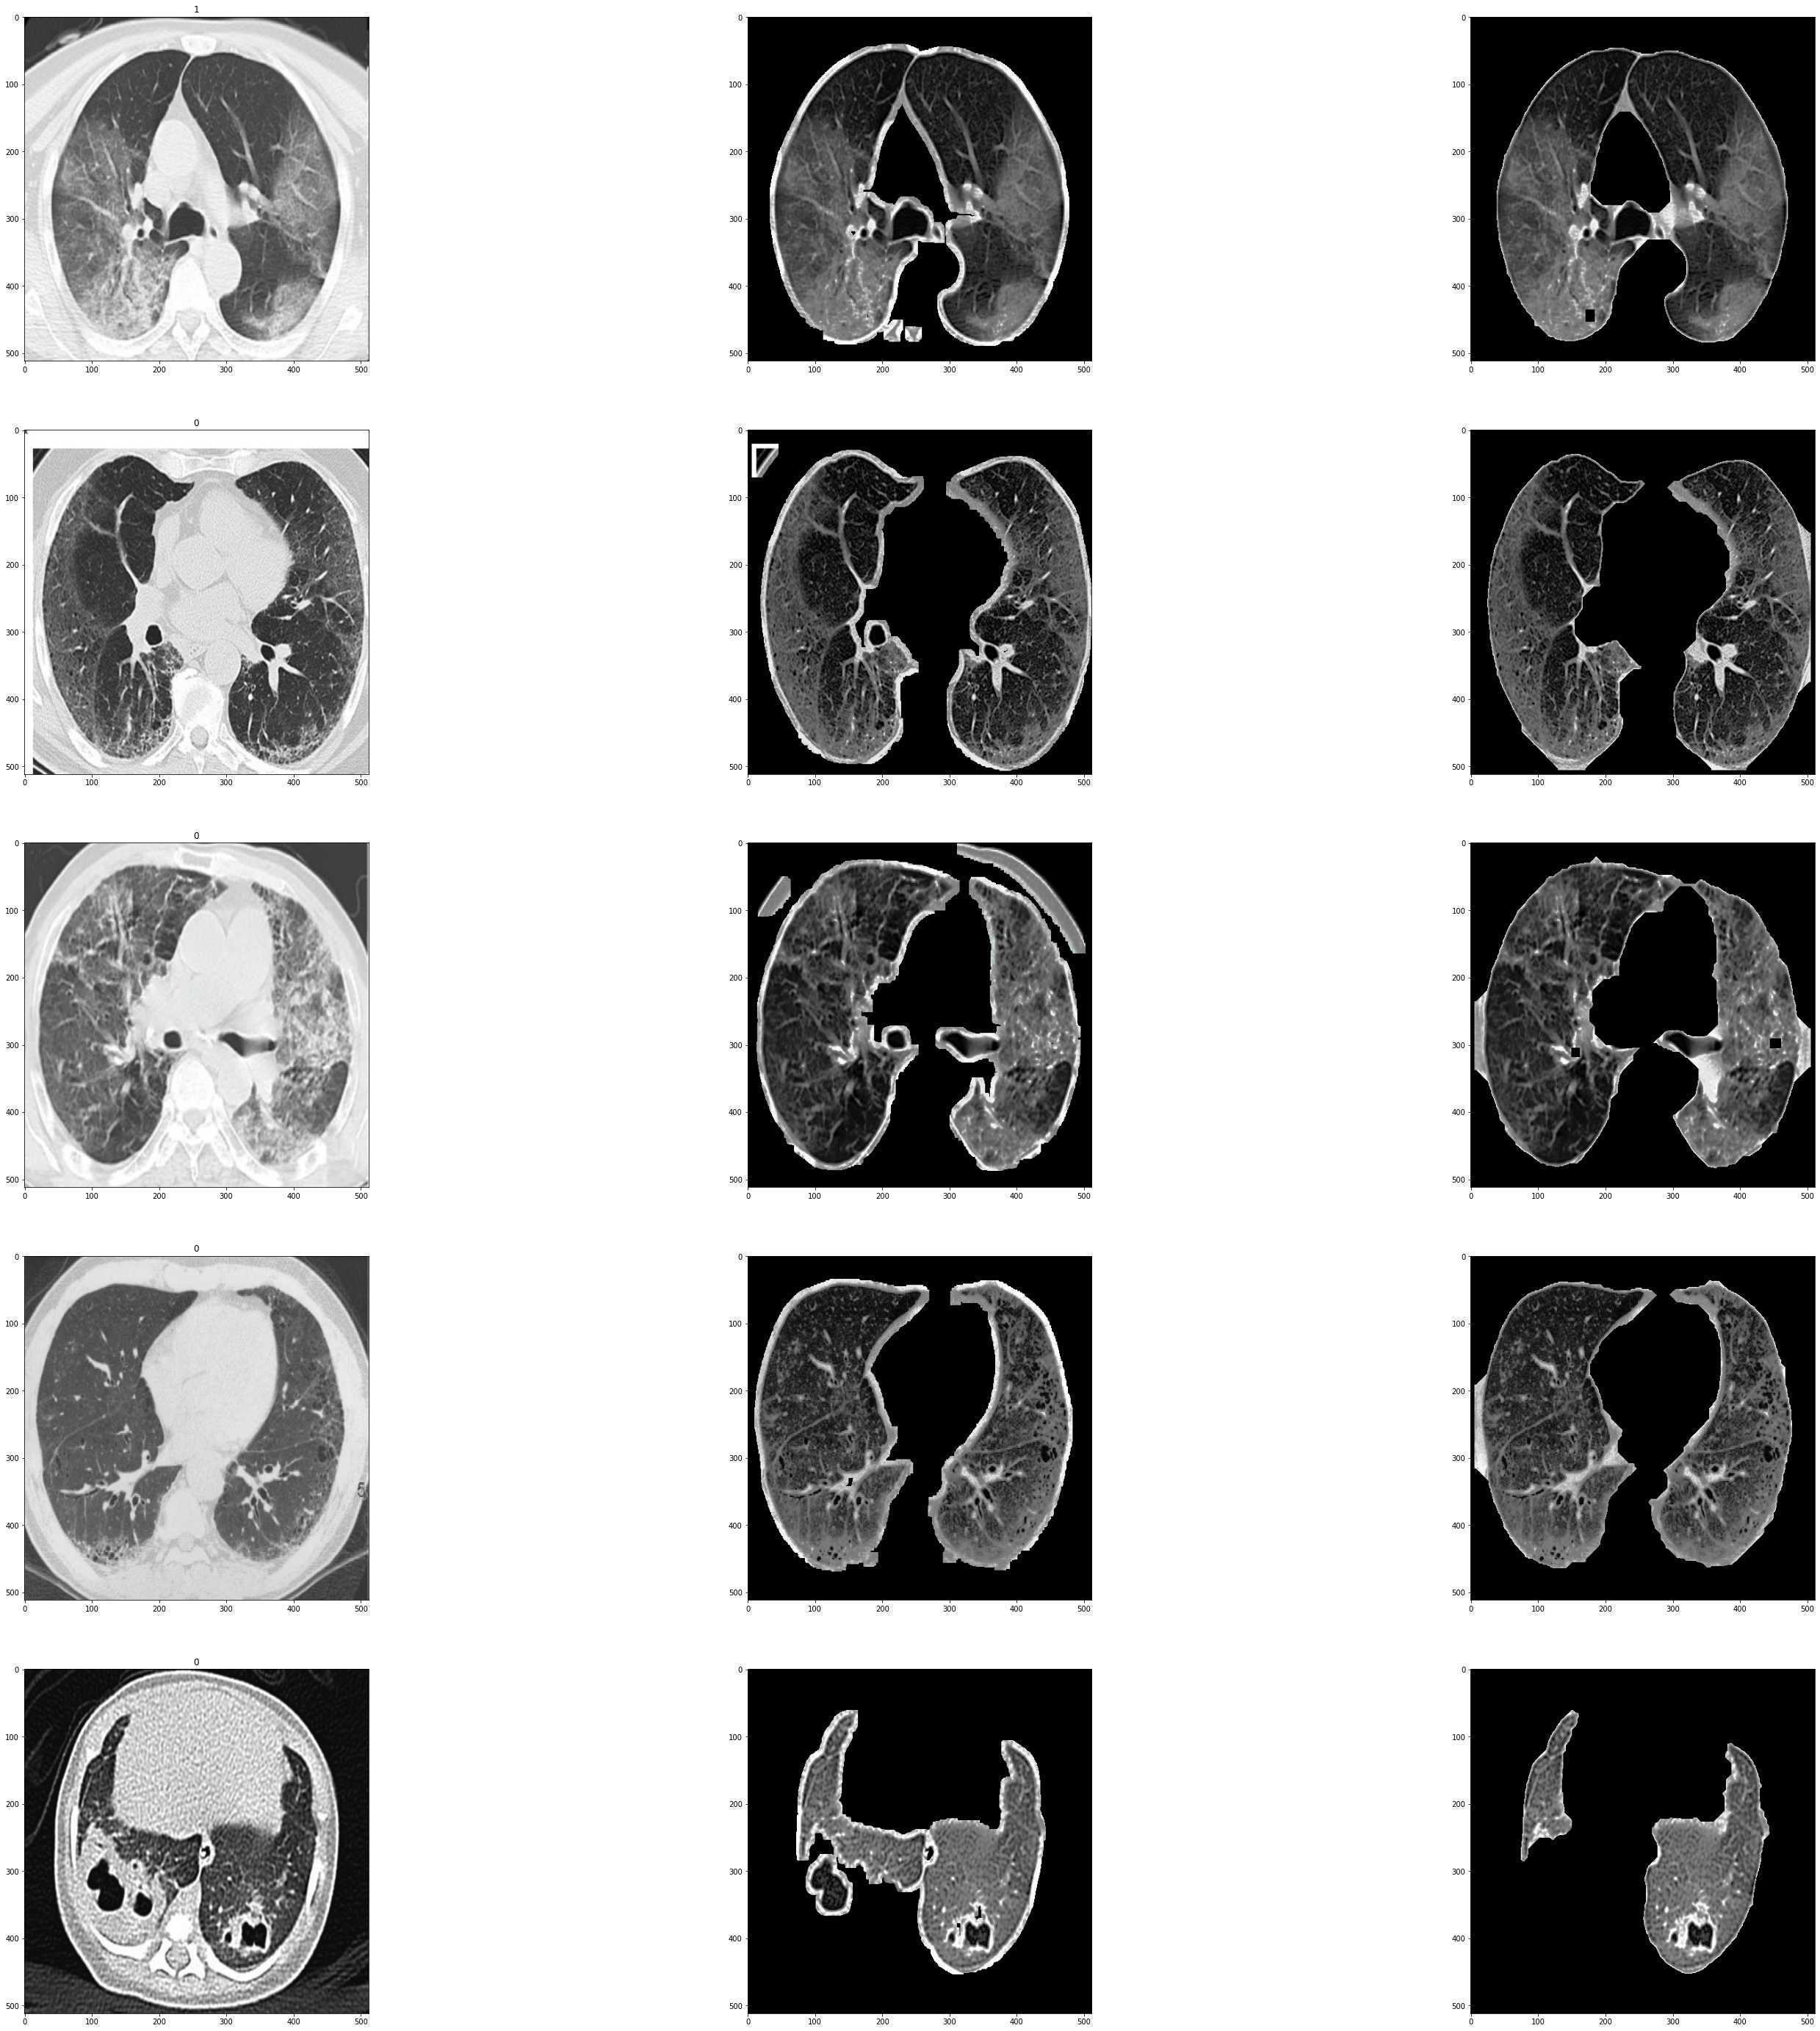

In [3]:
show_examples = 5
fig, ax = plt.subplots(show_examples, 3, figsize=(
    show_examples * 10, show_examples * 10))
images = [image.numpy() for images in train_dataset.take(1) for image in images]

for index in range(show_examples):
    example = images[0][index].astype('uint8')
    ax[index][0].set_title(images[1][index])
    ax[index][0].imshow(example)
    ax[index][1].imshow(segment_from_image(example)) # Naive
    ax[index][2].imshow(seperate_lungs(color.rgb2gray(exposure.equalize_hist(example)))[0], cmap='gray') # Watershed

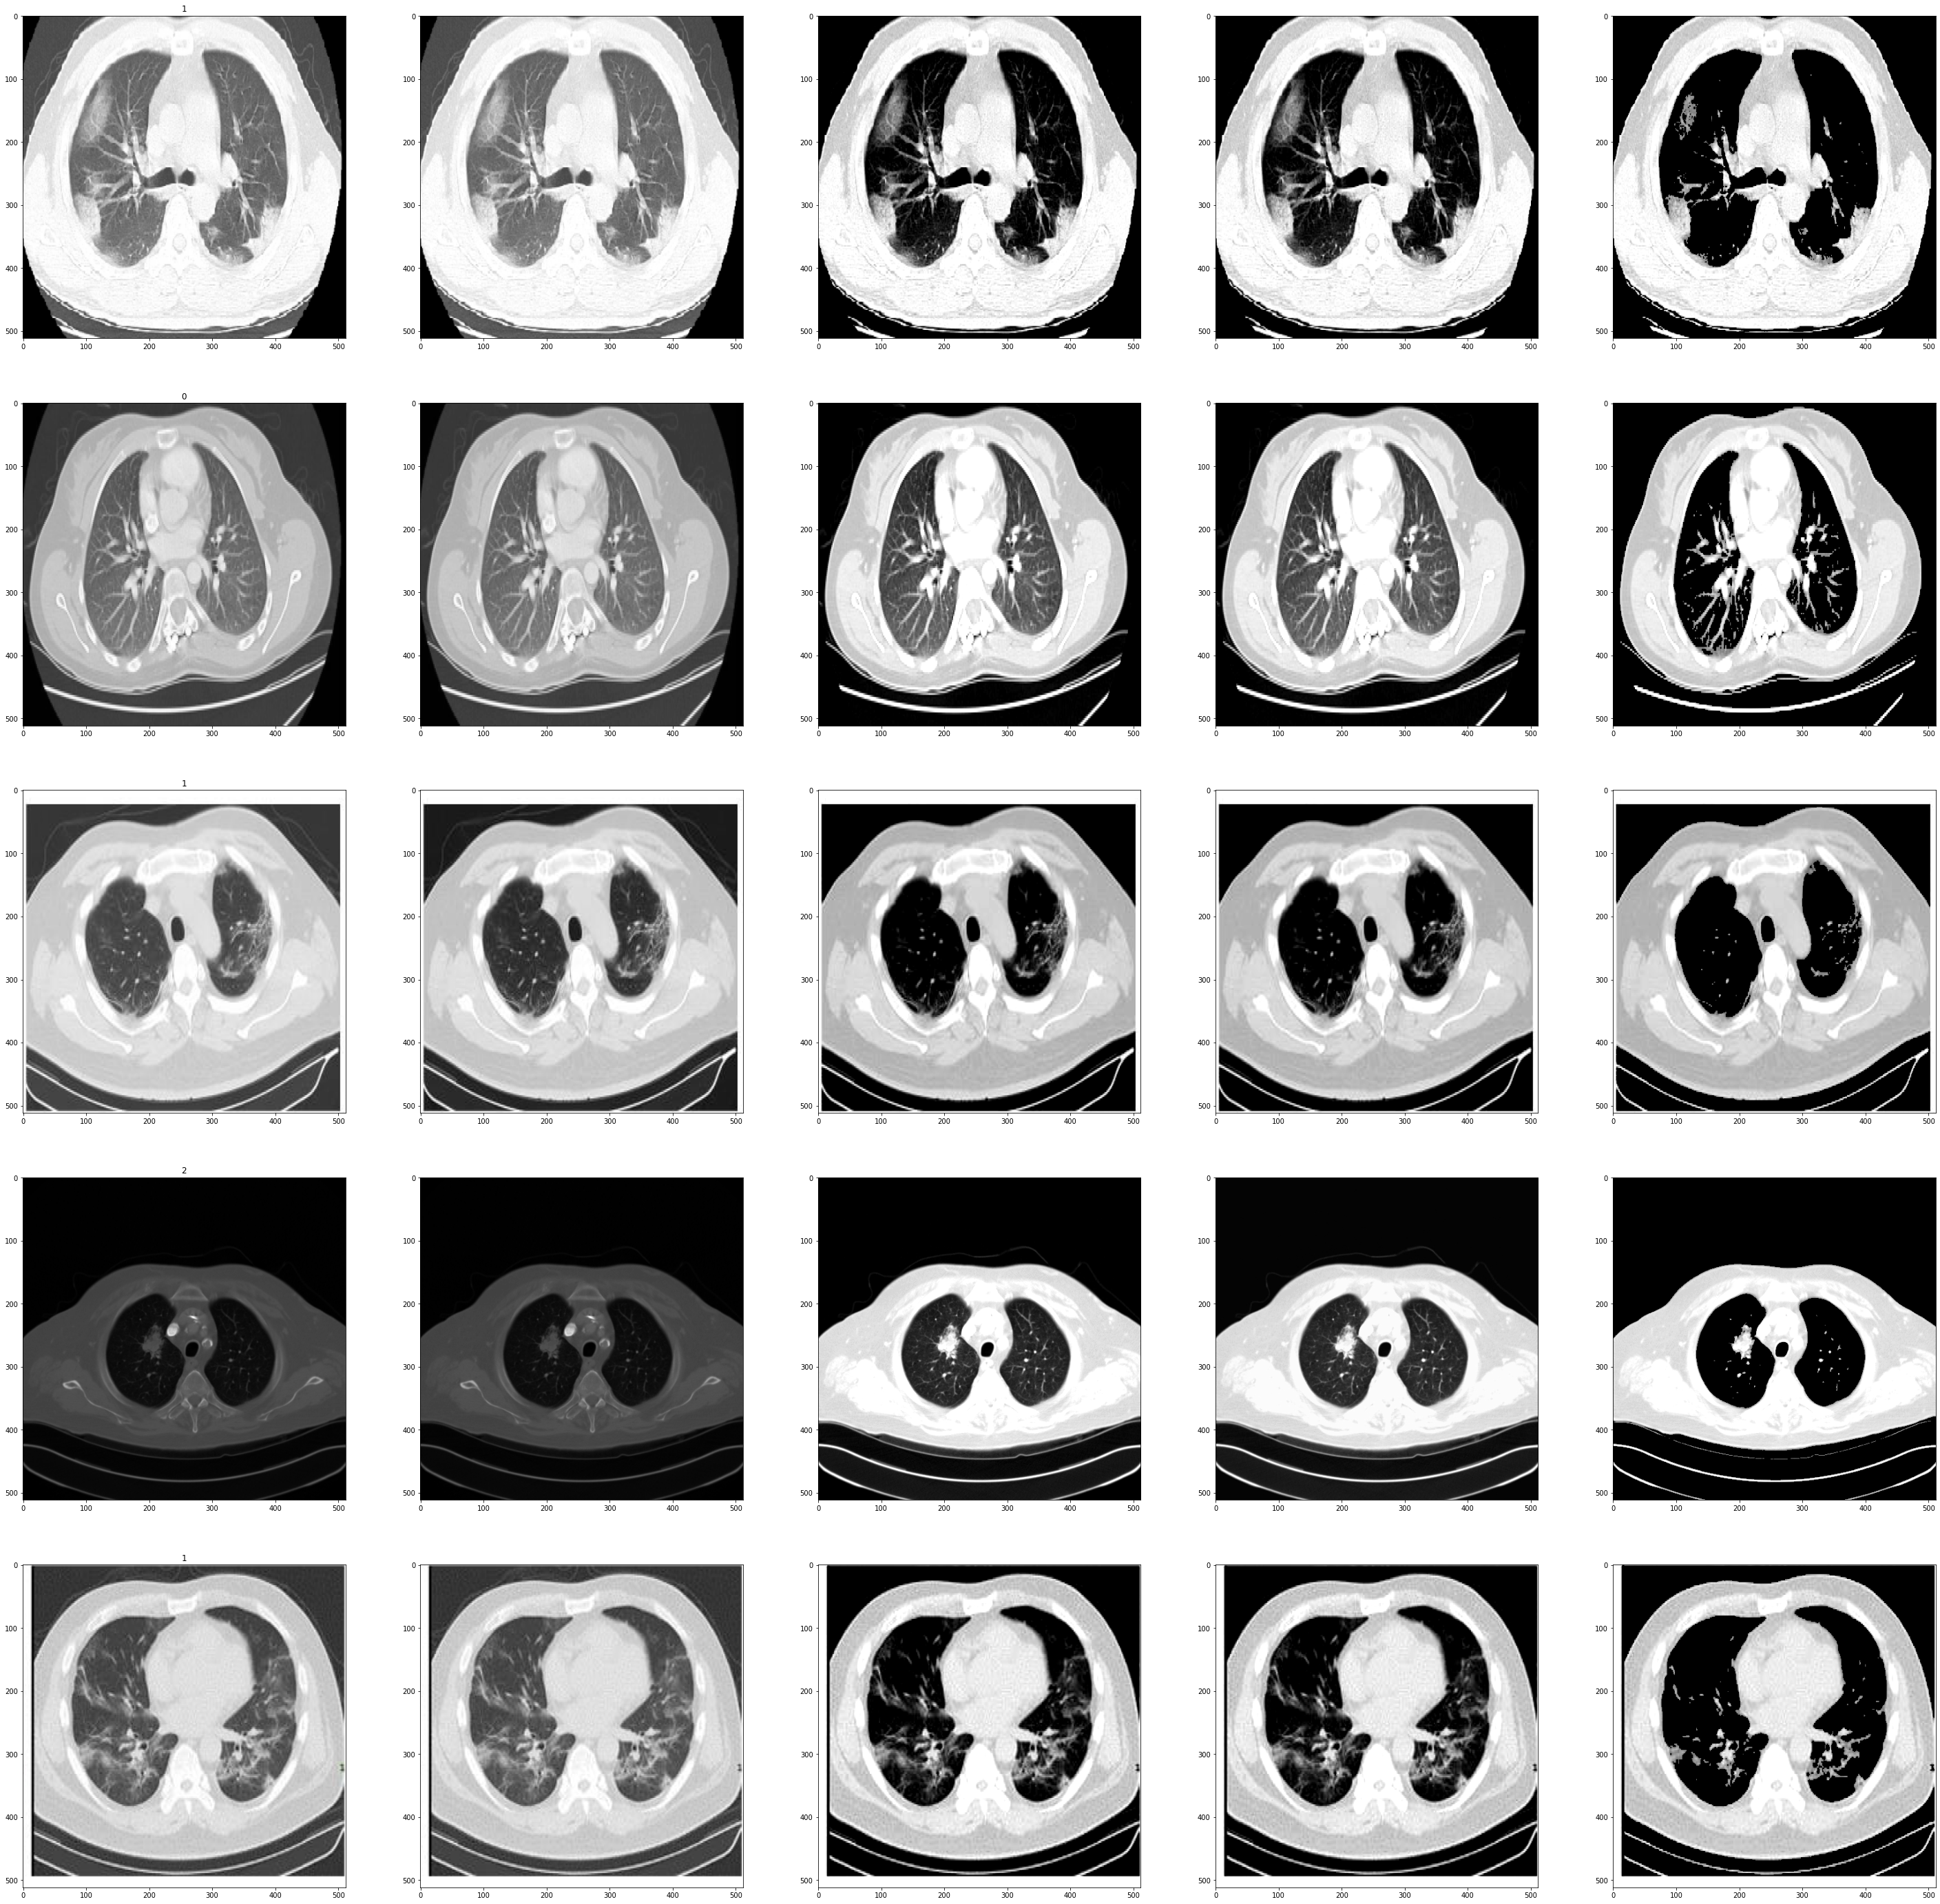

In [4]:
from skimage.exposure import rescale_intensity, equalize_adapthist, equalize_hist
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from skimage.restoration import denoise_wavelet

images, labels = [image.numpy() for images in train_dataset.take(1) for image in images]
show_examples = 5
fig, ax = plt.subplots(show_examples, 5, figsize=(show_examples * 10, show_examples * 10))

for index in range(show_examples):
    random_idx = np.random.randint(0, images.shape[0])
    image = images[random_idx]
    label = labels[random_idx]

    example = image.astype('uint8')
    grayscale = rgb2gray(example)
    lower, upper = np.percentile(grayscale, (25, 90))
    rescaled = rescale_intensity(grayscale, in_range=(lower, upper))
    denoised = denoise_wavelet(rescaled, method='BayesShrink', mode='soft', rescale_sigma=True)
    binary = denoised > threshold_otsu(denoised)
    final = binary * rescaled
    
    ax[index][0].set_title(label)
    ax[index][0].imshow(example)
    ax[index][1].imshow(grayscale, cmap='gray')
    ax[index][2].imshow(rescaled, cmap='gray')
    ax[index][3].imshow(denoised, cmap='gray')
    ax[index][4].imshow(final, cmap='gray')    

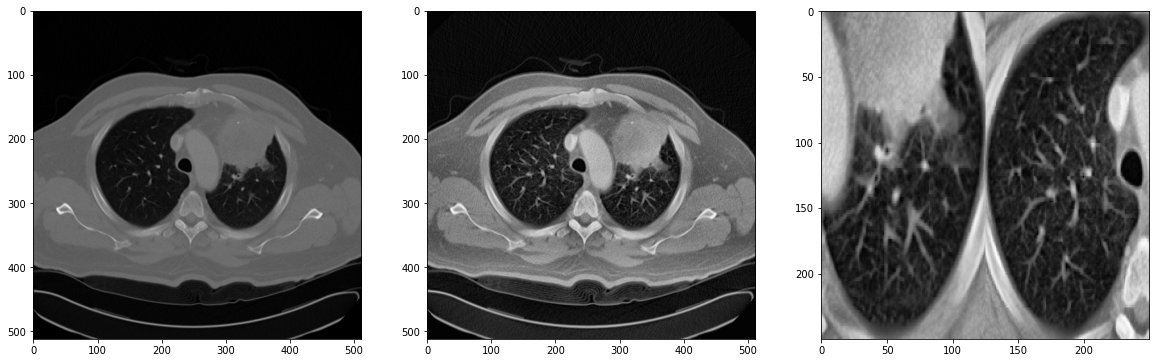

In [5]:
import cv2
import numpy as np
import pathlib
import random

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['image.cmap'] = 'gray'
fig, ax = plt.subplots(1, 3, figsize=(20, 10))

test_data_dir = pathlib.Path.cwd().parent / 'data/test_image/test_image'
test_image_files = [file for file in test_data_dir.iterdir()]
test_image_file = random.choice(test_image_files)
image = cv2.imread(str(test_image_file), 0)

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_image = clahe.apply(image)

blur = cv2.GaussianBlur(clahe_image, (5, 5), 0)
ret, thresh = cv2.threshold(blur, 50, 255, cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
areas = [cv2.contourArea(contour) for contour in contours]

x = np.argsort(areas)
max_index = x[x.size - 3]
cnt1 = contours[max_index]
second_max_index = x[x.size - 2]
cnt2 = contours[second_max_index]

x, y, w, h = cv2.boundingRect(cnt1)
p, q, r, s = cv2.boundingRect(cnt2)

cropped1 = clahe_image[y:y+h, x:x+w]
cropped1 = cv2.resize(cropped1, dsize=(125, 250), interpolation=cv2.INTER_AREA)
cropped2 = clahe_image[q:q+s, p:p+r]
cropped2 = cv2.resize(cropped2, dsize=(125, 250), interpolation=cv2.INTER_AREA)
fused = np.concatenate((cropped1, cropped2), axis=1)

ax[0].imshow(image)
ax[1].imshow(clahe_image)
ax[2].imshow(fused)

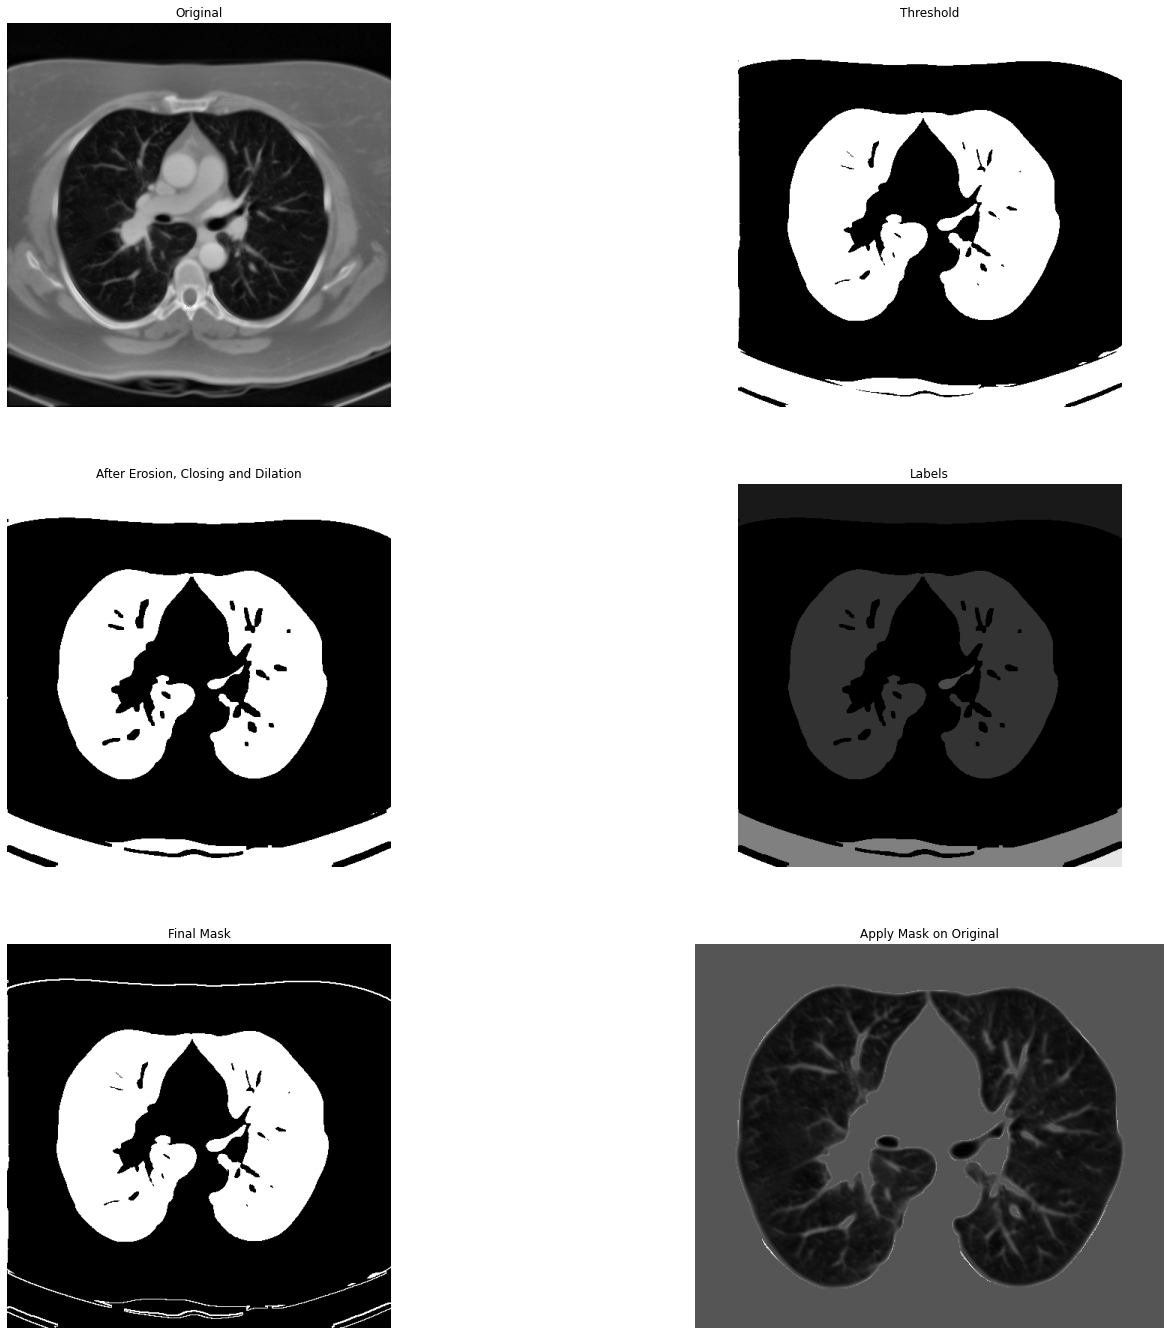

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import random
from typing import Any
from skimage import exposure, morphology, measure, restoration
from sklearn.cluster import KMeans


def transform(image_array, k_means_cluster=2, boundary_factor=5, display=True):
    """
    Transform using K-means segmentation
    from https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/ with small adjustments

    :param image_array: image array
    :param k_means_cluster: number of clusters
    :param boundary_factor: boundary to locate the center
    :return: transformed image
    """

    # Convert to grayscale and do basic transformation
    image_array = exposure.equalize_adapthist(image_array, clip_limit=0.01)
    image_array = restoration.denoise_bilateral(image_array)


    # Calculate image features
    row_size = image_array.shape[0]
    col_size = image_array.shape[1]

    (
        left_boundary,
        right_boundary,
    ) = row_size // boundary_factor, row_size // boundary_factor * (
        boundary_factor - 1
    )
    (
        up_boundary,
        down_boundary,
    ) = col_size // boundary_factor, col_size // boundary_factor * (
        boundary_factor - 1
    )

    # Normalize the data
    mean = np.mean(image_array)
    std = np.std(image_array)
    image_array = (image_array - mean) / std

    # Define middle zone
    middle = image_array[
        left_boundary:right_boundary, up_boundary:down_boundary
    ]
    middle_mean = np.mean(middle)
    max_pixel = np.max(image_array)
    min_pixel = np.min(image_array)

    # Offsetting max and min value to mean
    image_array[image_array == max_pixel] = middle_mean
    image_array[image_array == min_pixel] = middle_mean

    # K-means
    k_means = KMeans(n_clusters=k_means_cluster).fit(
        np.reshape(middle, (np.prod(middle.shape), 1))
    )
    centers = sorted(k_means.cluster_centers_.flatten())
    threshold = np.mean(centers)
    threshold_image = np.where(image_array < threshold, 1, 0)
    mask = np.where(image_array < threshold, 1, 0)

    # Morphological transformation
    eroded = morphology.erosion(mask, np.ones((4, 4)))
    dilation = morphology.dilation(eroded, np.ones((1, 1)))

    # Labelling
    labels = measure.label(dilation)
    labels = morphology.remove_small_objects(labels)
    regions = [
        (region.area, region.label, region.coords, region.bbox)
        for region in measure.regionprops(labels)
    ]
    selected_regions = []

    for region in regions:
        area, coords, box = region[0], region[2], region[3]
        select_current_label = False
        is_valid_shape = (
            box[2] - box[0] < row_size * 0.998
            and box[3] - box[1] < col_size * 0.998
            and abs(box[2] + box[0] - row_size) / row_size < 0.5
        )
        
        if is_valid_shape:
            select_current_label = True
        if select_current_label:
            selected_regions.append((area, box))
        for coord in coords:
            mask[coord[0], coord[1]] = 1 if select_current_label else 0

    # Final output
    pre_final = morphology.dilation(mask, np.ones((3, 3)))
    final = pre_final * image_array

    # Cropping
    if len(selected_regions) == 0:
        return final

    regions_bbox = np.array([region[1] for region in selected_regions]).T
    new_bbox = np.concatenate(
        (regions_bbox.min(axis=1)[:2], regions_bbox.max(axis=1)[2:])
    )
    min_r, min_c, max_r, max_c = new_bbox
    width = max_r - min_r
    height = max_c - min_c

    if height != width:
        if abs(height - width) % 2 == 0:
            min_r -= abs(height - width) // 2
            max_r += abs(height - width) // 2
            min_c -= abs(width - height) // 2
            max_c += abs(width - height) // 2
        else:
            min_r -= (abs(height - width) + 1) // 2
            max_r += (abs(height - width) - 1) // 2
            min_c -= (abs(width - height) + 1) // 2
            max_c += (abs(width - height) - 1) // 2

    min_r = max(0, min_r)
    min_c = max(0, min_c)
    final_cropped = final[min_r:max_r, min_c:max_c]
    
    if (display):
        original_cmap = plt.rcParams['image.cmap']
        plt.rcParams['image.cmap'] = 'gray'
        fig, ax = plt.subplots(3, 2, figsize=[24, 24])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(image_array)
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(threshold_image)
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion, Closing and Dilation")
        ax[1, 0].imshow(dilation)
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask)
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(final_cropped)
        ax[2, 1].axis('off')
        plt.show()
        plt.rcParams['image.cmap'] = original_cmap
        
    return final

test_data_dir = pathlib.Path.cwd().parent / 'data/test_image/test_image'
test_image_files = [file for file in test_data_dir.iterdir()]
test_image_files.sort(key=lambda file: int(file.stem))

test_image_file = random.choice(test_image_files)
image = cv2.imread(str(test_image_file), 0)
result = transform(image, k_means_cluster=2, boundary_factor=10, display=True)